In [37]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import numpy as np
import yaml
import pandas as pd
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [38]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup, set_axs_configuration
from auriga.settings import Settings
from auriga.parser import parse

In [39]:
figure_setup()
settings = Settings()

In [40]:
CONFIG_FILE = "02"
config = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))

In [41]:
DISC_STD_CIRC = config["DISC_STD_CIRC"]
DISC_MIN_CIRC = config["DISC_MIN_CIRC"]
COLD_DISC_DELTA_CIRC = config["COLD_DISC_DELTA_CIRC"]
BULGE_MAX_SPECIFIC_ENERGY = config["BULGE_MAX_SPECIFIC_ENERGY"]
SUFFIX = config["FILE_SUFFIX"]

In [42]:
def read_data(simulation: str, config: dict) -> pd.DataFrame:
    """
    This method returns the circularity and the normalized potential for the
    stars in the main object of the simulation.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    pd.DataFrame
        A Pandas dataframe with the relevant data.
    """
    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.tag_particles_by_region(
        disc_std_circ=config["DISC_STD_CIRC"],
        disc_min_circ=config["DISC_MIN_CIRC"],
        cold_disc_delta_circ=config["COLD_DISC_DELTA_CIRC"],
        bulge_max_specific_energy=config["BULGE_MAX_SPECIFIC_ENERGY"]
    )

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)
    mask = is_real_star & is_main_obj

    df = pd.DataFrame(
        {
            "Circularity": s.circularity[mask],
            "NormalizedPotential": s.normalized_potential[mask],
            "NormalizedSpecificEnergy": s.normalized_specific_energy[mask],
            "CylindricalRadius_ckpc": s.rho[mask],
            "z_ckpc": s.pos[mask, 2],
            "TangentialVelocity_km/s": s.v_phi[mask],
            "ComponentTag": s.region_tag[mask]
        }
    )

    return df

In [43]:
df = read_data(simulation="au6_or_l4_s127", config=config)

### Figures

In [44]:
XLIM = (0, 20)
YLIM = (-XLIM[1] / 2, XLIM[1] / 2)
N_BINS = 40

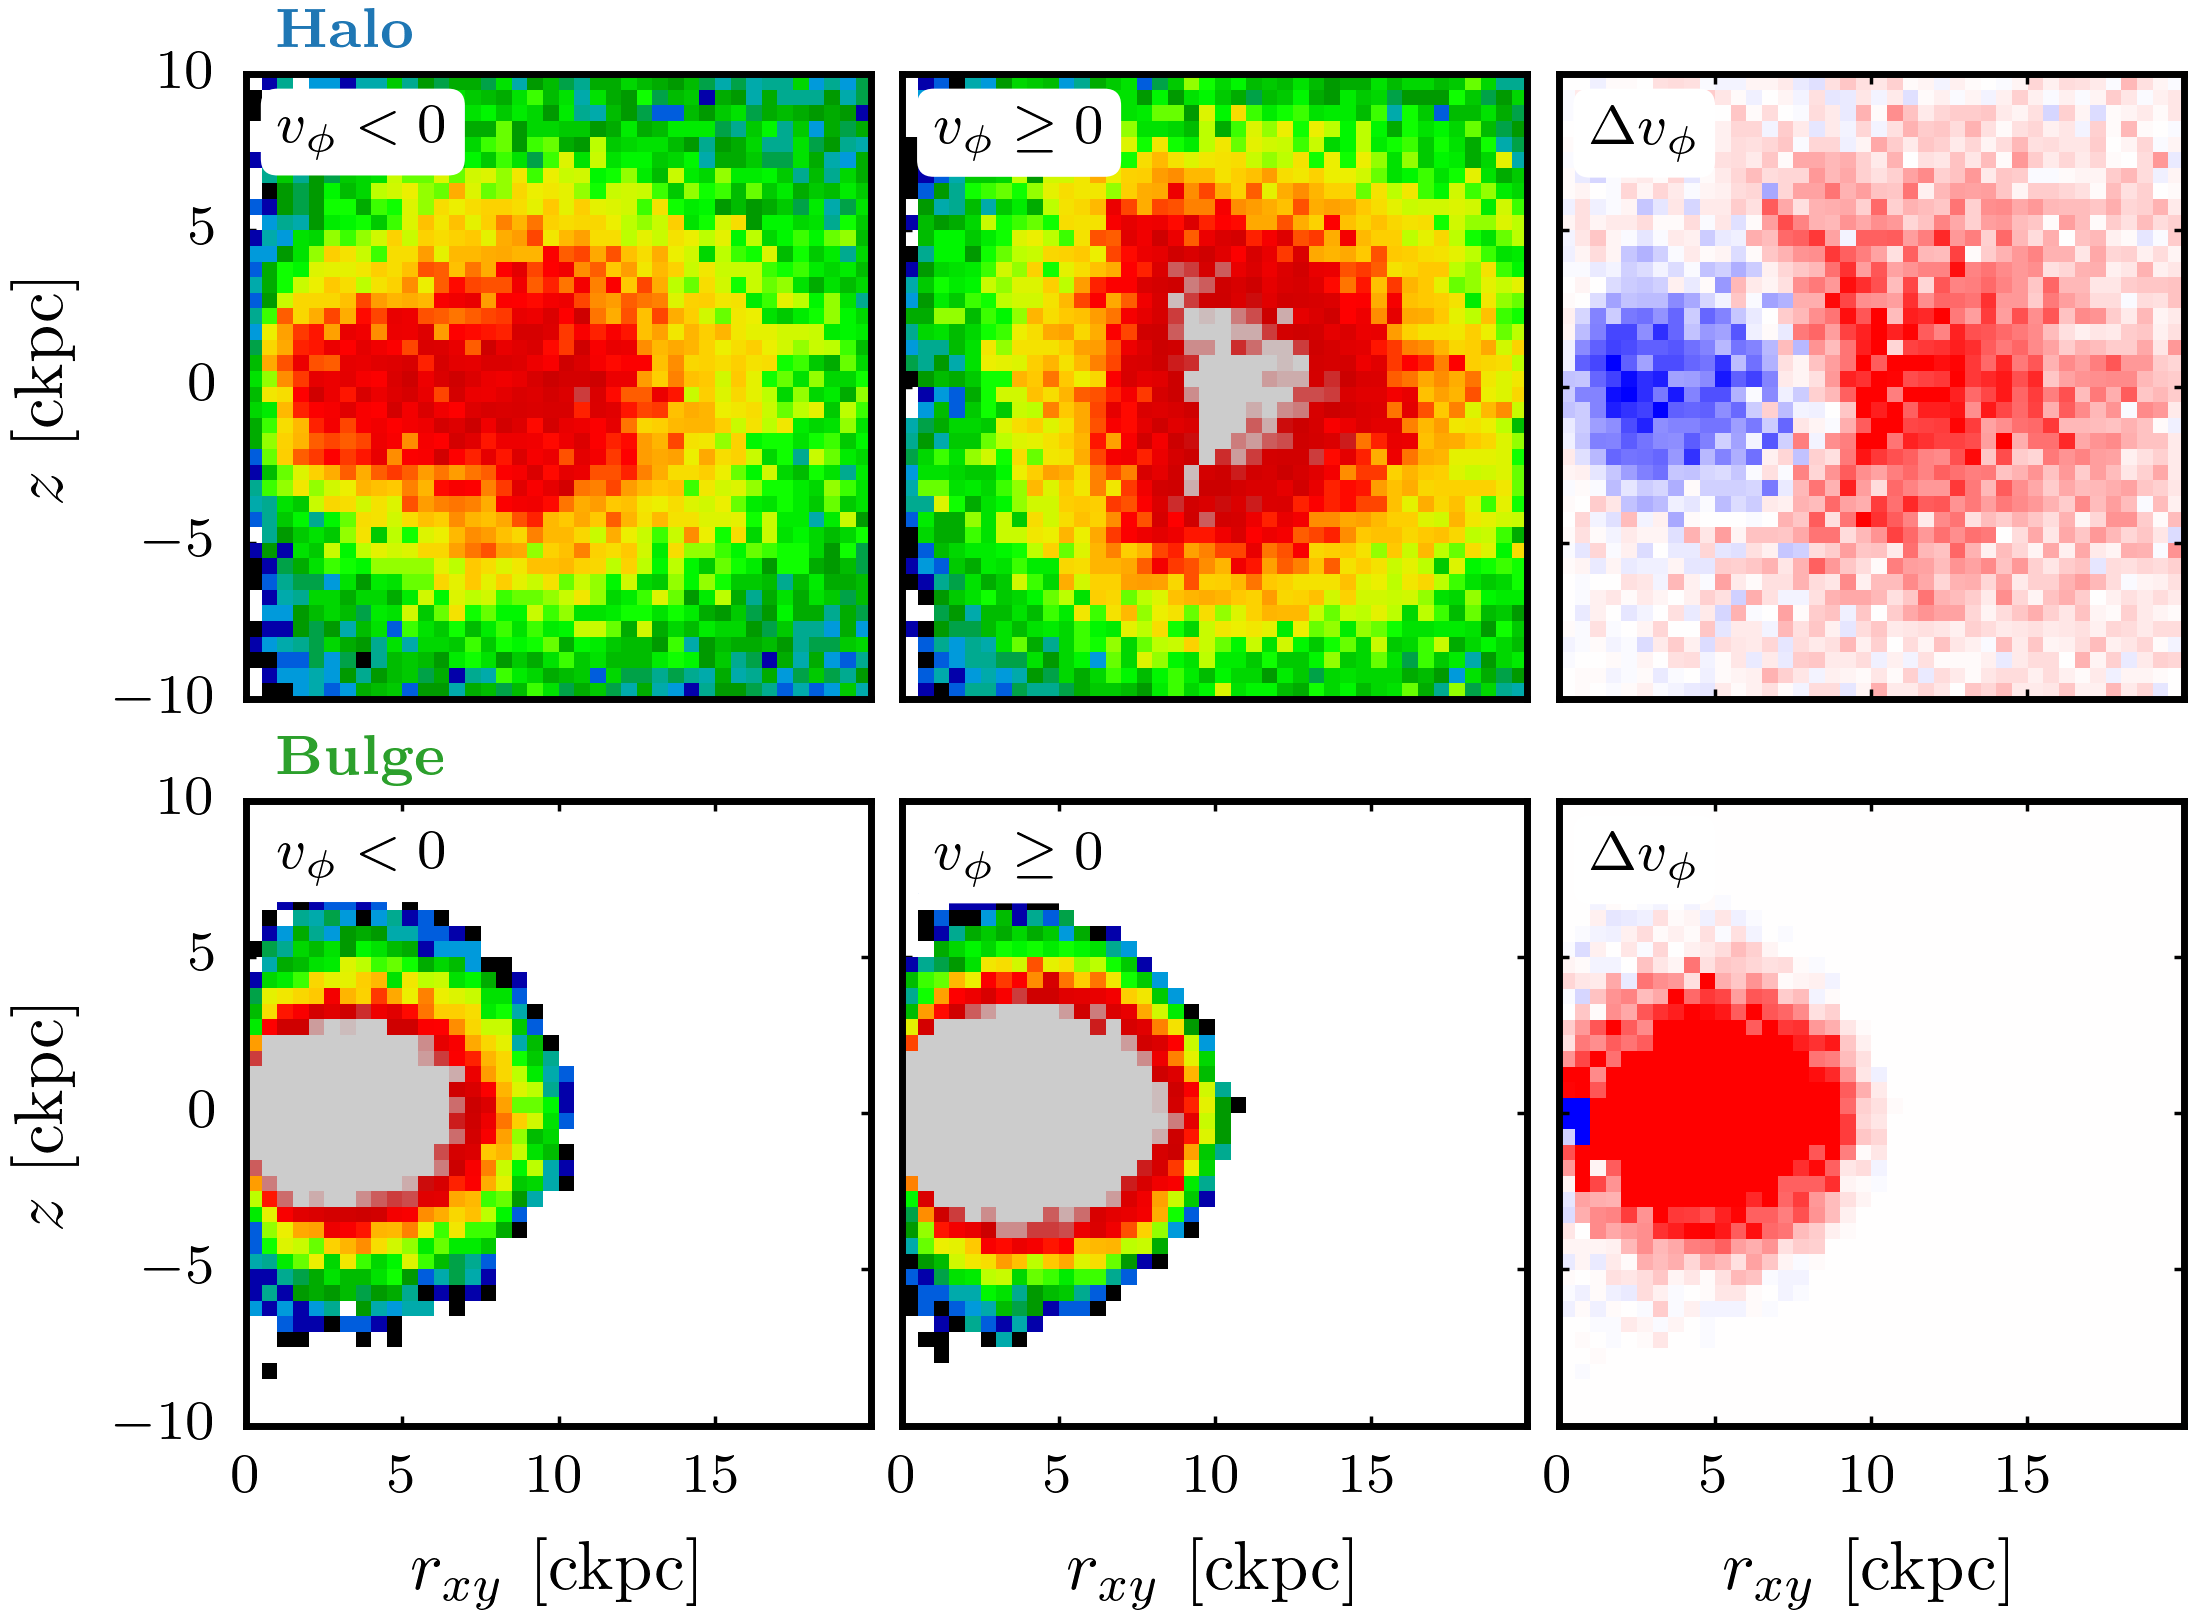

In [59]:
fig = plt.figure(figsize=(5.0, 3.75))
gs = fig.add_gridspec(nrows=2, ncols=3, hspace=0.0, wspace=0.05)
axs = gs.subplots(sharex=True, sharey=True)

for ax in axs.flatten():
    ax.tick_params(which='both', direction="in")
    ax.set_axisbelow(True)
    ax.set_xlim(XLIM)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xlabel(r'$r_{xy}$ [ckpc]')
    ax.set_ylim(YLIM)
    ax.set_ylabel(r'$z$ [ckpc]')
    ax.label_outer()
    ax.set_aspect("equal")

is_negative_rotation = df["TangentialVelocity_km/s"] < 0.0

for i, c in enumerate(["H", "B"]):
    is_component = df["ComponentTag"] == settings.component_tags[c]

    h1, _, _, _ = axs[i, 0].hist2d(
        df[is_negative_rotation & is_component]["CylindricalRadius_ckpc"],
        df[is_negative_rotation & is_component]["z_ckpc"],
        cmap='nipy_spectral', bins=N_BINS,
        range=[ax.get_xlim(), ax.get_ylim()],
        norm=mcolors.LogNorm(vmin=1, vmax=100), rasterized=True)
    h2, _, _, _ = axs[i, 1].hist2d(
        df[~is_negative_rotation & is_component]["CylindricalRadius_ckpc"],
        df[~is_negative_rotation & is_component]["z_ckpc"],
        cmap='nipy_spectral', bins=N_BINS,
        range=[ax.get_xlim(), ax.get_ylim()],
        norm=mcolors.LogNorm(vmin=1, vmax=100), rasterized=True)
    im = axs[i, 2].imshow(
        (h2 - h1).T, aspect="equal", extent=(axs[i, 2].get_xlim()[0],
                                             axs[i, 2].get_xlim()[1],
                                             axs[i, 2].get_ylim()[0],
                                             axs[i, 2].get_ylim()[1]),
        vmin=-50, vmax=50, origin="lower",
        cmap='bwr', rasterized=True, interpolation="none")

    props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, lw=0)
    axs[i, 0].text(s=r"$\textbf{" + settings.component_labels[c] + r"}$",
                   x=0.05, y=1.025, size=8,
                   va="bottom", ha="left", color=settings.component_colors[c],
                   transform=axs[i, 0].transAxes)

    axs[i, 0].text(s=r"$v_\phi < 0$", x=0.05, y=0.95, size=8,
                   va="top", ha="left", color="black",
                   transform=axs[i, 0].transAxes, bbox=props)
    axs[i, 1].text(s=r"$v_\phi \geq 0$", x=0.05, y=0.95, size=8,
                   va="top", ha="left", color="black",
                   transform=axs[i, 1].transAxes, bbox=props)
    axs[i, 2].text(s=r"$\Delta v_\phi$", x=0.05, y=0.95, size=8,
                   va="top", ha="left", color="black",
                   transform=axs[i, 2].transAxes, bbox=props)

plt.show()